In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import time
# import gget
import anndata as an
import scanpy as sc
import scanpy.external as sce
import h5py
import scipy
from scipy.stats import pearsonr
from scipy.stats import t
from scipy.spatial.distance import cdist
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, FuncFormatter


from scipy.spatial.distance import pdist, squareform
from collections import defaultdict

sc.settings.verbosity = 2

The data below are dCt values (relative to LDLR) for Control and Dox-treated samples (n=3 biological replicates each) (1 ug/ml dox)

From F2HS\#24, 1 ug/ml dox, day 3

In [2]:
df = pd.DataFrame({
    "Sample" : ['Control_1', 'Control_2', 'Control_3', 'FH4a_1', 'FH4a_2', 'FH4a_3'],
    "GATA2" : [-9.522, -9.865, -8.42, 2.49, 2.63, 2.13],
    "GFI1B" : [-11.37, -11.061, -9.5, -4.94, -4.33, -4.49],
    "FOS" : [-14.09, -13.67, -13.31, 3.11, 3.27, 2.75],
    "STAT5A": [-10.057, -11.028, -9.14, 4.22, 4.41, 3.99],
    "REL" : [-9.862, -9.804, -10.81, -1.39, -1.74, -2.57],
})

df = df.set_index('Sample')
df

,GATA2,GFI1B,FOS,STAT5A,REL
Sample,,,,,
Control_1,-9.522,-11.370,-14.09,-10.057,-9.862
Control_2,-9.865,-11.061,-13.67,-11.028,-9.804
Control_3,-8.420,-9.500,-13.31,-9.140,-10.810
FH4a_1,2.490,-4.940,3.11,4.220,-1.390
FH4a_2,2.630,-4.330,3.27,4.410,-1.740
FH4a_3,2.130,-4.490,2.75,3.990,-2.570


In [3]:
genes = ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']

plot_df = pd.DataFrame(index=df.index)

for gene in genes:
    # select rows for control samples
    ctrl_rows = df.iloc[0:3]
    # get average ctrl value for each gene
    avg_ctrl = ctrl_rows[gene].mean()
    # get ddCt per gene
    plot_df[gene] = df[gene] - avg_ctrl
    
plot_df   

,GATA2,GFI1B,FOS,STAT5A,REL
Sample,,,,,
Control_1,-0.253,-0.726333,-0.40,0.018,0.296667
Control_2,-0.596,-0.417333,0.02,-0.953,0.354667
Control_3,0.849,1.143667,0.38,0.935,-0.651333
FH4a_1,11.759,5.703667,16.80,14.295,8.768667
FH4a_2,11.899,6.313667,16.96,14.485,8.418667
FH4a_3,11.399,6.153667,16.44,14.065,7.588667


In [4]:
plot_df['Condition'] = plot_df.index.str.split('_').str[0]  # extract 'Control' or 'FH4a'
plot_df['Replicate'] = plot_df.index.str.split('_').str[1]

df_long = plot_df.melt(
    id_vars=['Condition', 'Replicate'],
    var_name='Gene',
    value_name='Expression'
)

reprogram_name = '5TF'
ctrl_name = 'control'

df_long['Condition'] = df_long['Condition'].replace('FH4a', reprogram_name)
df_long['Condition'] = df_long['Condition'].replace('Control', ctrl_name)

df_long

,Condition,Replicate,Gene,Expression
0,control,1,GATA2,-0.253000
1,control,2,GATA2,-0.596000
2,control,3,GATA2,0.849000
3,5TF,1,GATA2,11.759000
4,5TF,2,GATA2,11.899000
5,5TF,3,GATA2,11.399000
6,control,1,GFI1B,-0.726333
7,control,2,GFI1B,-0.417333
8,control,3,GFI1B,1.143667
9,5TF,1,GFI1B,5.703667


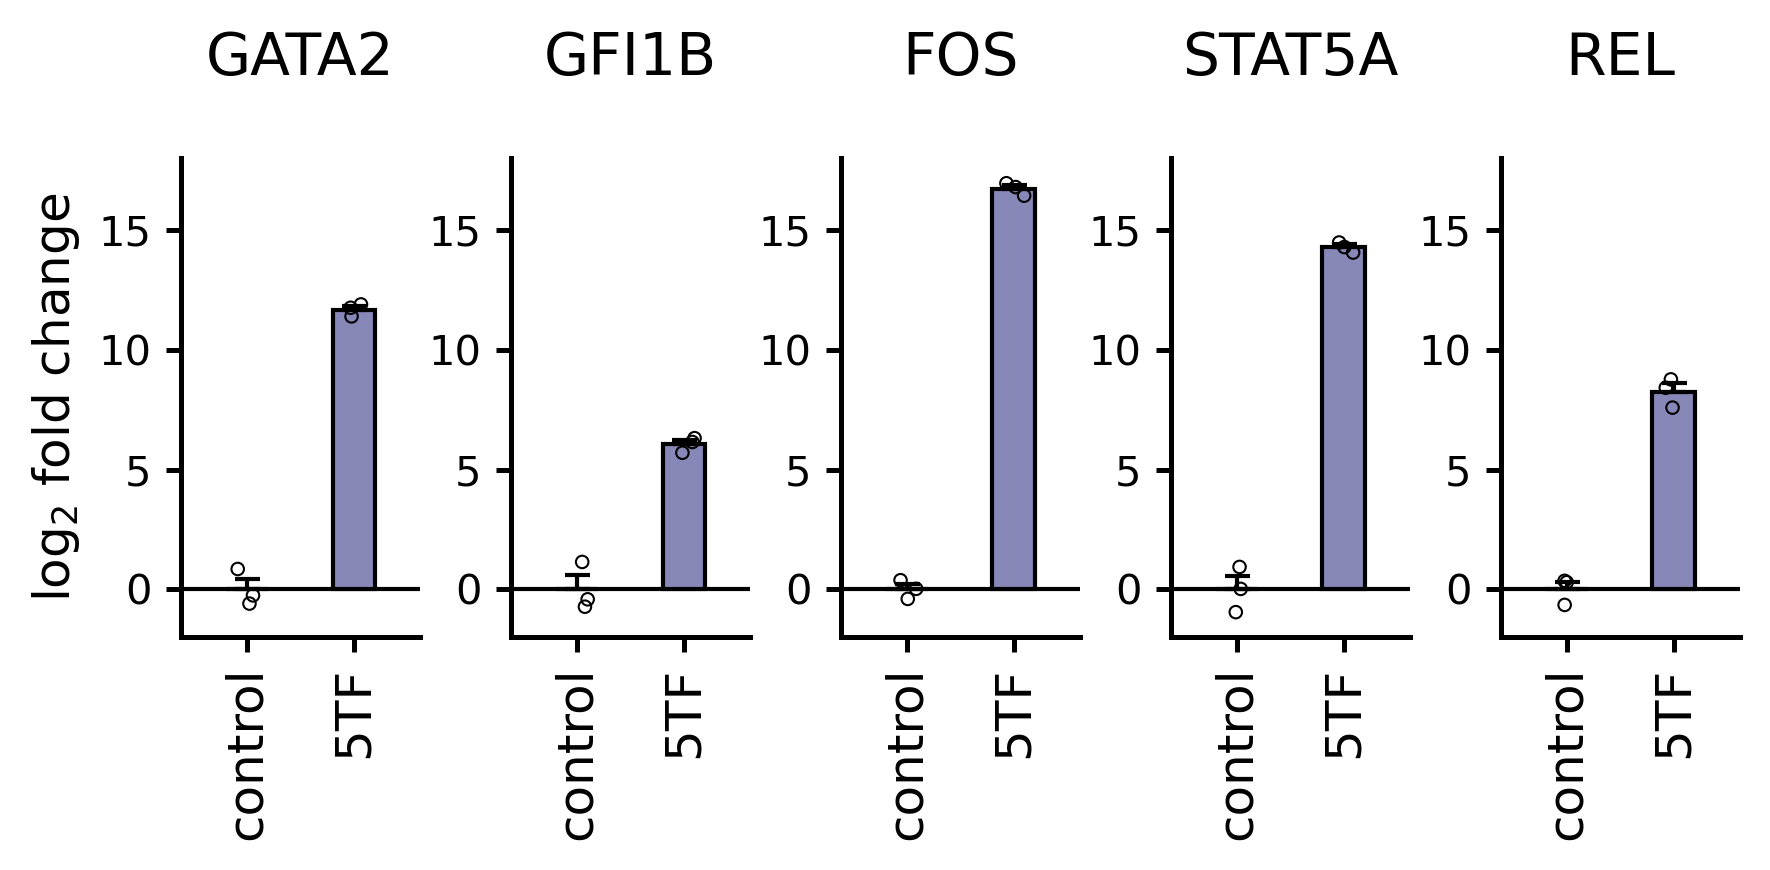

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

gene_order = ['GATA2', 'GFI1B', 'FOS', 'STAT5A', 'REL']
order = [ctrl_name, reprogram_name]
palette = ['gray', '#8080C0']
line_width = 1.2

fig, axs = plt.subplots(1, 5)#, sharey=True)

for i, gene in enumerate(gene_order):
    tmp = df_long[df_long['Gene'] == gene]
    ax=axs[i]
    
    sns.barplot(
        data=tmp,
        x='Condition',
        y='Expression',
        hue='Condition',
        errorbar=None,
        capsize=0.2,
        width=0.4,
        ec='k',
        linewidth=1,
        palette=palette,
        ax=ax,
    )
    
    # add errorbars
    stats = tmp.groupby('Condition')['Expression'].agg(['mean', 'sem']).reindex(order)
    ax.errorbar(
        x=np.arange(len(order)),
        y=stats['mean'],
        yerr=[np.zeros(len(order)), stats['sem']],
        fmt='none',
        color='k',
        elinewidth=1,
        capsize=3, # 4
        zorder=10,
    )
    
    sns.stripplot(
        data=tmp,
        x='Condition',
        y='Expression',
        marker='o',
        # dodge=True,
        jitter=0.1,
        size=3,
        edgecolor='k',
        linewidth=0.5,
        facecolors='none',
        ax=ax,
    )
    
    ax.set_title(gene, fontsize=14, pad=20) # 15
    ax.set_ylabel("log$_2$ fold change", fontsize=12) if i==0 else ax.set_ylabel("")
    ax.set_xlabel("")
    
    ax.axhline(y=0, ls='-', lw=1, color='k', zorder=0)

    ax.set_ylim([-2, 18])
    ax.set_yticks([0, 5, 10, 15])
    ax.margins(y=0.075)
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(nbins=4, integer=True)
    )
    
    ax.margins(x=0.3)
    ax.tick_params(axis='x', rotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='both', width=line_width)
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
    
sns.despine()
plt.tight_layout(w_pad=0.2) # 1.5
plt.show()    

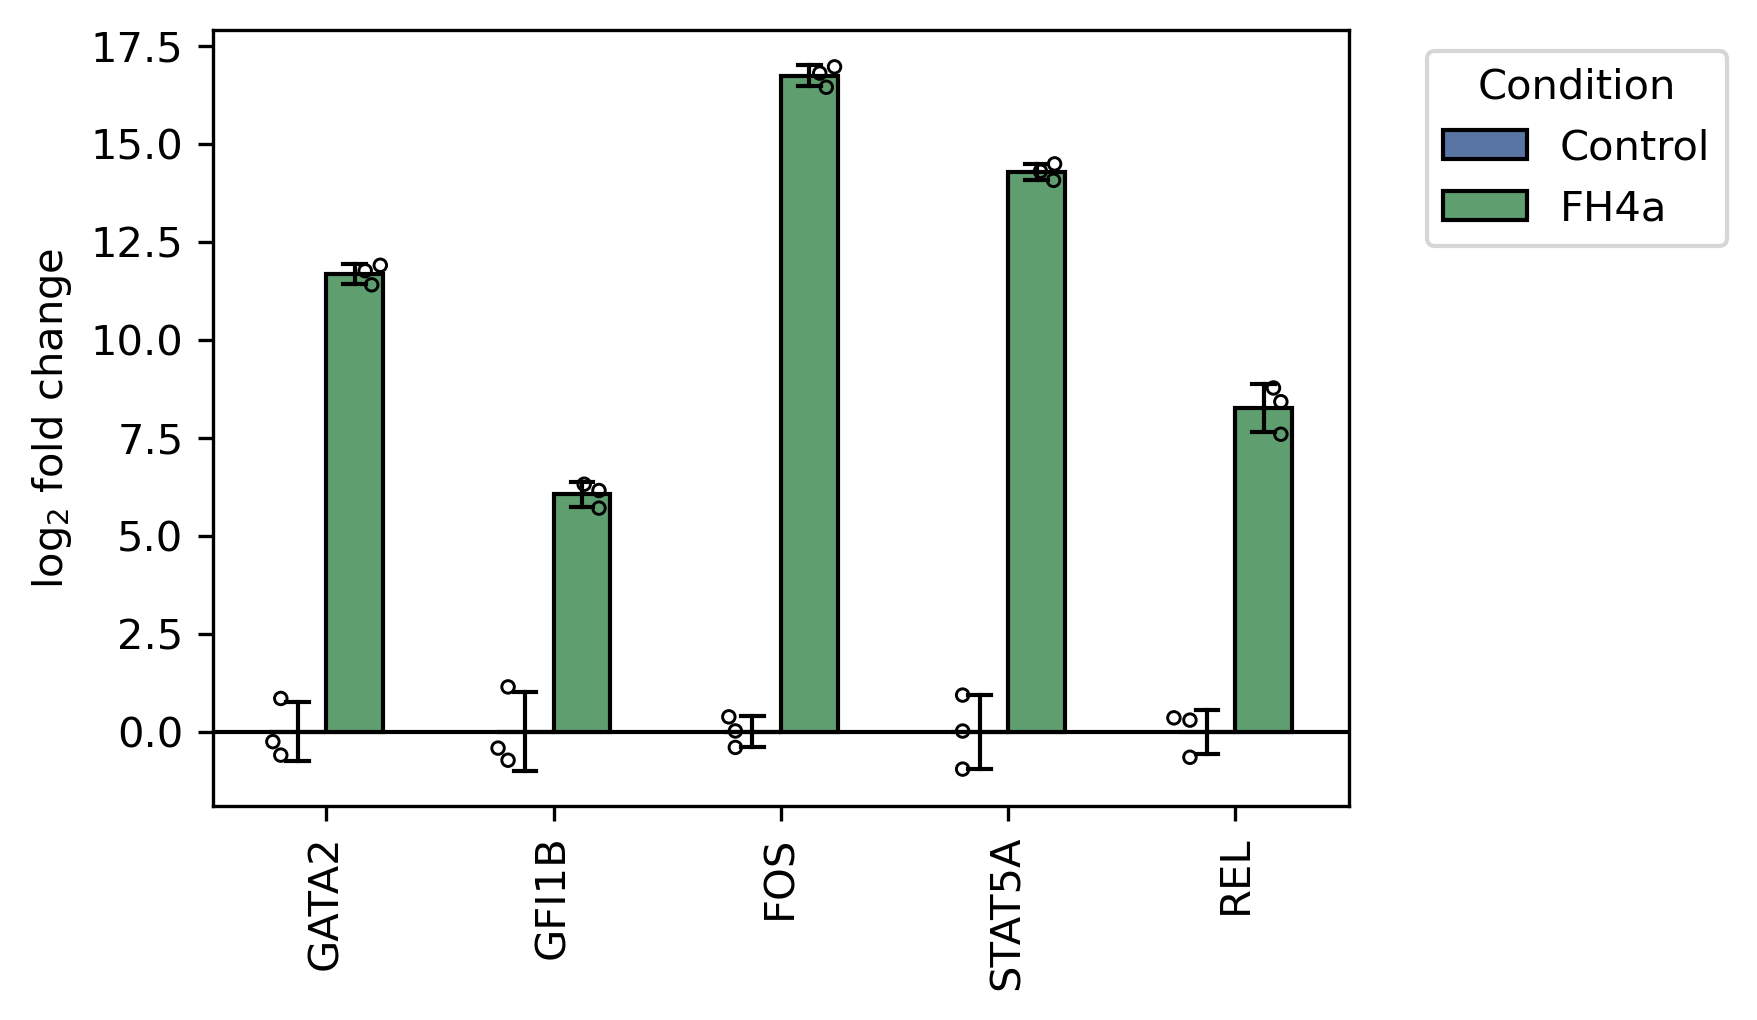

In [64]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3.5

gene_order = df_long['Gene'].unique()
hue_order = ['Control', 'FH4a']
palette = {'Control': '#4C72B0', 'FH4a': '#55A868'}

ax = sns.barplot(
    data=df_long,
    x='Gene',
    y='Expression',
    hue='Condition',
    order=gene_order,
    hue_order=hue_order,
    errorbar='sd',
    err_kws={'linewidth': 1, 'color':'k'},
    capsize=0.2,
    width=0.5,
    ec='k',
    linewidth=1,
    palette=palette,
    # zorder=2,
)


# strip = sns.stripplot(
#     data=df_long,
#     x='Gene',
#     y='Expression',
#     hue='Condition',
#     dodge=True,
#     jitter=True,
#     marker='o',
#     # alpha=1,
#     linewidth=0.7,
#     edgecolor='k',
#     size=3,
#     # facecolors='none',
#     order=gene_order,
#     hue_order=hue_order,
#     ax=ax,
#     # kwargs={'facecolors': 'none'},
# )

strip = sns.swarmplot(
    data=df_long,
    x='Gene',
    y='Expression',
    hue='Condition',
    dodge=True,
    # jitter=True,
    marker='o',
    # alpha=1,
    linewidth=0.7,
    edgecolor='k',
    size=3,
    order=gene_order,
    hue_order=hue_order,
    ax=ax,
)

for artist in strip.collections:
    artist.set_facecolor('none')
    artist.set_edgecolor('k')
    artist.set_linewidth(0.7)
    artist.set_alpha(1)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[:2], labels[:2], title='Condition',
    bbox_to_anchor=(1.05, 1), loc='upper left',
)

plt.ylabel("log$_2$ fold change")
plt.xlabel("")

plt.xticks(rotation=90)

plt.axhline(y=0, ls='-', lw=1, color='k', zorder=0)

plt.tight_layout()
plt.show()